# Final Project (part 9)
#### By Shubhankar Kumar

### 8. Similarity analysis of Subject using LSH

In [15]:
import re
from pyspark.ml.feature import MinHashLSH
from pyspark.ml.feature import CountVectorizer,  IDF, CountVectorizerModel, Tokenizer, RegexTokenizer, StopWordsRemover
from pyspark.ml.feature import StopWordsRemover 
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql import Row
import pyspark.sql.functions as F

In [2]:
import pandas as pd
import numpy as np
from itertools import compress 
from pyspark.sql.functions import *
from pyspark.sql.types import *
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 10)
pd.reset_option('display.max_rows', 10)
pd.set_option('display.max_colwidth', 500)


warnings.filterwarnings(action='ignore')

In [3]:
import time
import pyspark
sc = spark.sparkContext
print('Original spark.driver.maxResultSize: ' + sc._conf.get('spark.driver.maxResultSize'))
sc.stop()

# Waiting for the environment to stop
sleep_time = 30
print(f'Waiting for {sleep_time} seconds for the enviroment to stop...')
time.sleep(sleep_time)

# Applying new configuration and restarting Spark
conf = pyspark.SparkConf().setAll([('spark.driver.maxResultSize', '16g')])
sc = pyspark.SparkContext(conf=conf)

print('New spark.driver.maxResultSize: ' + sc._conf.get('spark.driver.maxResultSize'))

# Starting  Spark session with configs applied
spark = SparkSession(sc).builder.getOrCreate()

Original spark.driver.maxResultSize: 1920m
Waiting for 30 seconds for the enviroment to stop...


23/12/08 05:00:47 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
23/12/08 05:00:47 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
23/12/08 05:00:47 INFO org.apache.spark.SparkEnv: Registering BlockManagerMasterHeartbeat
23/12/08 05:00:47 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator


New spark.driver.maxResultSize: 16g


In [4]:
commits_df = spark.read.parquet("gs://msca-bdp-students-bucket/shared_data/shubhankark/samplecommits")

In [5]:
df = commits_df

In [6]:
del commits_df

In [7]:
# Adding an 'id' column to df: the IDs are not necessarily consecutive but are guaranteed to be unique across the entire DataFrame.
df = df.withColumn("id", monotonically_increasing_id())

# Splitting text into words
df = df.withColumn("words", split(col("subject"), " "))

# Removing punctuation and split into words
df = df.withColumn("clean_text", F.regexp_replace(F.col("subject"), "[\p{P}\p{C}]", ""))
df = df.withColumn("words", split(F.col("clean_text"), " "))

# Filtering out tokens that are less than 3 characters
df = df.withColumn("clean_words", F.expr("filter(words, word -> length(word) > 1)"))

# Removing stopwords
remover = StopWordsRemover(inputCol="clean_words", outputCol="filtered_words")
df = remover.transform(df)

In [8]:
vectorize = CountVectorizer(inputCol="filtered_words", outputCol="features", minDF=1.0)
df_vectorize = vectorize.fit(df).transform(df)

In [9]:
from pyspark.sql.functions import udf
from pyspark.ml.linalg import Vectors, VectorUDT, SparseVector, DenseVector

def ensure_non_zero_vector(v):
    if v is None:
        return Vectors.dense([0.1])  # Replace with an appropriate non-zero vector
    elif isinstance(v, SparseVector) and v.numNonzeros() == 0:
        # For sparse vector with all zeros, add a non-zero entry
        return Vectors.dense([0.1] + [0.0] * (len(v) - 1))
    elif isinstance(v, DenseVector) and all(x == 0 for x in v.toArray()):
        # For dense vector with all zeros, add a non-zero entry
        return Vectors.dense([0.1] + [0.0] * (len(v) - 1))
    else:
        return v  # Return the vector as-is if it's not all zeros

ensure_non_zero_vector_udf = udf(ensure_non_zero_vector, VectorUDT())

df_vectorize_subject_no_zero = df_vectorize.withColumn("features", ensure_non_zero_vector_udf("Features"))

In [10]:
numHashTables = 5 
mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=numHashTables)
model = mh.fit(df_vectorize_subject_no_zero)
df_hashed_text = model.transform(df_vectorize_subject_no_zero)

In [11]:
jaccard_distance = 0.6

# Perform similarity join
df_dups_text = model.approxSimilarityJoin(df_hashed_text, df_hashed_text, jaccard_distance).filter("datasetA.id < datasetB.id").select(
    col("distCol"),
    col("datasetA.id").alias("id_A"),
    col("datasetB.id").alias("id_B"),
    col('datasetA.subject').alias('subject_A'),
    col('datasetB.subject').alias('subject_B'),
    col('datasetA.message').alias('message_A'),
    col('datasetB.message').alias('message_B')
)

In [12]:
records_sample = df_hashed_text.count()
dups_sample = df_dups_text.select('id_A').distinct().count()
uniques_sample = records_sample - dups_sample

# Display the results
print('Total records (sample): ', records_sample)
print('Duplicate articles based on Jaccard distance {} (sample): {}'.format(jaccard_distance, dups_sample))
print('Unique articles based on Jaccard distance {} (sample): {}'.format(jaccard_distance, uniques_sample))

Total records (sample):  5032
Duplicate articles based on Jaccard distance 0.6 (sample): 1074
Unique articles based on Jaccard distance 0.6 (sample): 3958


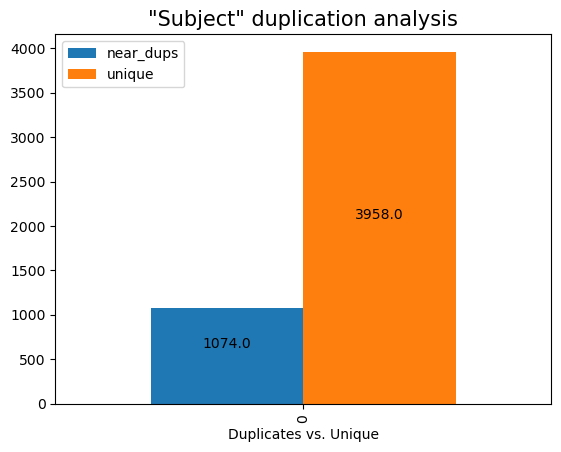

In [14]:
dups_df = pd.DataFrame.from_dict({'near_dups': [dups_sample], 'unique': [uniques_sample]})

ax=dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('"Subject" duplication analysis', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 